In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_time = pd.read_csv("Timedomain_Features_10s.csv")

In [3]:
data_time = data_time.iloc[:,1:]

In [4]:
data_time['Operation'] = pd.Categorical(data_time['Operation'])

In [5]:
train_data, test_data = train_test_split(data_time, test_size = 750, stratify = data_time['Operation'],
                                         random_state = 1234)
test_data['Operation'].value_counts() # Stratify equal proportion of fault type in traing and testiing

Operation
Dumping    247
Idling     175
Hauling    169
Loading    159
Name: count, dtype: int64

In [6]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.iloc[:,:-1]) # fit calcuated mean and std 

In [7]:
test_data_scaled = (test_data.iloc[:,:-1].values - scaler.mean_)/np.sqrt(scaler.var_)

In [8]:
import pickle
pickle.dump(scaler,open('scaling.pkl','wb'))

In [9]:
parameters = {"C":[1, 10, 50, 100, 300, 500],
             'gamma':[0.01, 0.05, 0.1, 0.5, 1, 5],
             'kernel':["rbf"]}

In [10]:
tuned_svm_clf = GridSearchCV(SVC(),parameters,n_jobs = -1, cv= 10)

In [11]:
tuned_svm_clf.fit(train_data_scaled, train_data['Operation'])

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 300, 500],
                         'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'kernel': ['rbf']})

In [12]:
tuned_svm_clf.best_score_

np.float64(0.9360320971695119)

In [13]:
tuned_svm_clf.best_params_

{'C': 50, 'gamma': 0.5, 'kernel': 'rbf'}

In [14]:
best_clf = tuned_svm_clf.best_estimator_
best_clf

SVC(C=50, gamma=0.5)

In [15]:
train_predictions = best_clf.predict(train_data_scaled)
test_predictions = best_clf.predict(test_data_scaled)

In [16]:
train_confu_matrix = confusion_matrix(train_data['Operation'], train_predictions)
test_confu_matrix = confusion_matrix(test_data['Operation'], test_predictions)

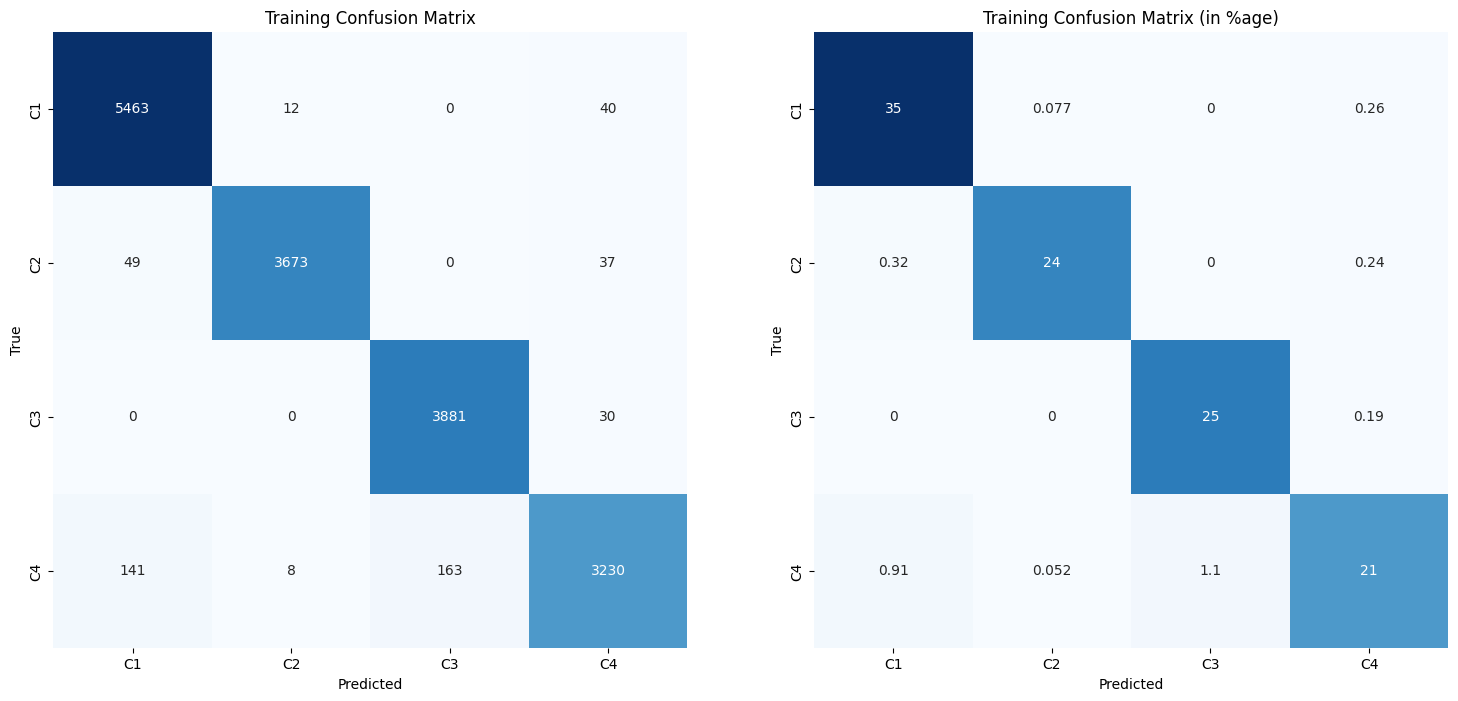

In [17]:
fault_type = ['C1','C2','C3','C4']
plt.figure(1,figsize=(18,8))
plt.subplot(121)
sns.heatmap(train_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(train_confu_matrix/155, annot= True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Training Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


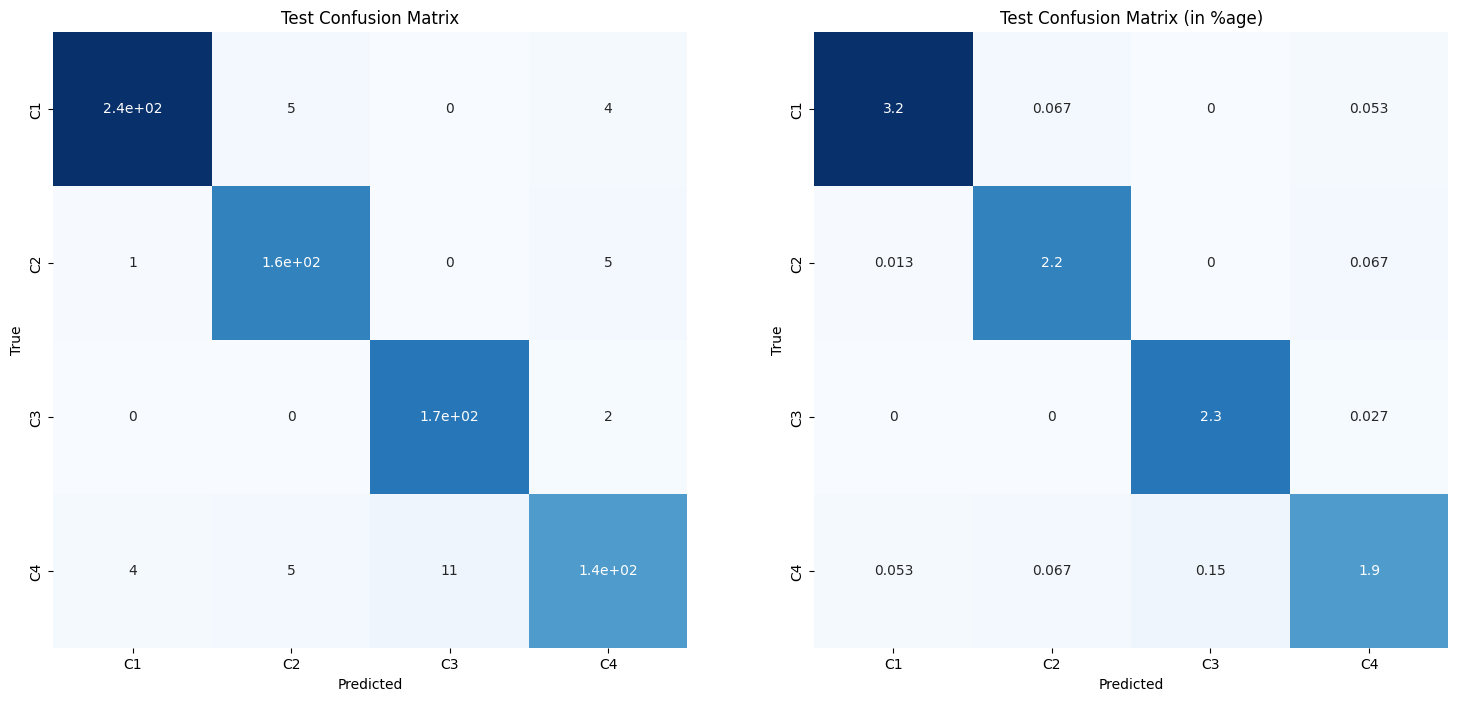

In [18]:
plt.figure(2,figsize=(18,8))
plt.subplot(121)
sns.heatmap(test_confu_matrix, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.subplot(122)
sns.heatmap(test_confu_matrix/75, annot = True,
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix (in %age)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
overall_test_accuracy = accuracy_score(test_data['Operation'], test_predictions)
print("Overall test accuracy: ", overall_test_accuracy)

Overall test accuracy:  0.9506666666666667


In [20]:
pickle.dump(best_clf,open('model.pkl','wb'))

In [21]:
pickled_model=pickle.load(open('model.pkl','rb'))